In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

warnings.filterwarnings("ignore")
%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-12-08 19:15:03.763438: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 19:15:03.783119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 19:15:03.783141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 19:15:03.783626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 19:15:03.786805: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_dir = '../data/splits/train'
batch_size = 50 
img_size = (256, 256)

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_dir = '../data/splits/validate'  
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=50,
    class_mode='categorical'
)

Found 4999 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [3]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  
])

2023-12-08 19:15:04.614310: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 19:15:04.614416: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 19:15:04.614461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [5]:
epochs=10
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size  
)

Epoch 1/10


2023-12-08 19:15:05.534325: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2023-12-08 19:15:05.574714: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-08 19:15:05.914315: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-08 19:15:06.210102: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f807cd38f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-08 19:15:06.210121: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2023-12-08 19:15:06.213107: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702084506.255595 2400868 device_compiler.

99/99 [==============================] - 8s 54ms/step - loss: 1.6102 - accuracy: 0.1922 - val_loss: 1.5921 - val_accuracy: 0.2140
Epoch 2/10
99/99 [==============================] - 5s 45ms/step - loss: 1.4625 - accuracy: 0.3587 - val_loss: 1.1188 - val_accuracy: 0.5920
Epoch 3/10
99/99 [==============================] - 4s 45ms/step - loss: 1.1836 - accuracy: 0.5286 - val_loss: 0.9548 - val_accuracy: 0.6440
Epoch 4/10
99/99 [==============================] - 5s 46ms/step - loss: 1.0021 - accuracy: 0.6201 - val_loss: 0.7493 - val_accuracy: 0.7340
Epoch 5/10
99/99 [==============================] - 4s 45ms/step - loss: 0.8636 - accuracy: 0.6761 - val_loss: 0.6022 - val_accuracy: 0.7900
Epoch 6/10
99/99 [==============================] - 5s 45ms/step - loss: 0.7051 - accuracy: 0.7373 - val_loss: 0.6064 - val_accuracy: 0.7840
Epoch 7/10
99/99 [==============================] - 4s 45ms/step - loss: 0.5960 - accuracy: 0.7810 - val_loss: 0.5514 - val_accuracy: 0.8320
Epoch 8/10
99/99 [======

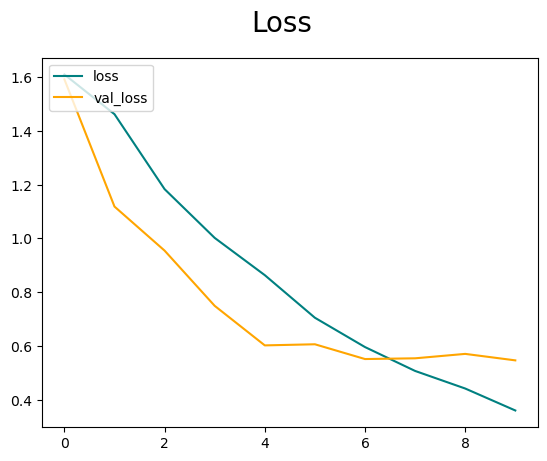

In [6]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [8]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                         kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                         activation='relu',
                         input_shape=self.input_shape))
        model.add(MaxPooling2D(2, 2))
        for i in range(hp.Int('n_layers', 1, 3)):
            model.add(Conv2D(filters=hp.Int(f'conv_{i+2}_filter', min_value=32, max_value=128, step=16),
                             kernel_size=hp.Choice(f'conv_{i+2}_kernel', values=[3, 5]),
                             activation='relu'))
            model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=16), activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))  # Assuming 5 classes

        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model

hypermodel = CNNHyperModel(input_shape=(256, 256, 3))

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='../models',
    project_name='cnn_tuning'
)

tuner.search(train_generator,
             epochs=10,
             validation_data=val_generator)


Trial 10 Complete [00h 00m 49s]
val_accuracy: 0.7279999852180481

Best val_accuracy So Far: 0.7960000038146973
Total elapsed time: 00h 09m 55s
